# Table of contents

- [Introduction](#intro)
- [Import libraries and dataset](#lib)
- [Checking Null/NA values ](#na)
- [Preprocessing Date and convert into Datatime format](#predate)
- [Perform Exploratory Data Analysis(EDA)](#eda)
    - [Find the duration of dataset](#dur)
    - [Monthwise comparision between Stock open and close price](#oc)
    - [Monthwise High and Low stock price](#hl)
    - [Trend comparision between stock open price, close price, high price, low price](#trend)
- [Preprare Stock Close price](#sc)
    - [Make separate dataframe](#df)
    - [Plot stock close price](#pclose)
- [Consider only 1 year data for prediction](#year)
    - [Normalizing close price](#norm)
    - [Split Train and Test ](#split)
    - [Transform Close price base on Time-series-analysis forecasting requirement](#trans)
- [Model Building (GRU) ](#gru)
- [Plotting Loss chart](#loss)
- [Model Evaluation](#eval)
    - [Evaluation metrices RMSE, MSE and MAE](#mse)
    - [Explained variance regression score](#var)
    - [R<sup>2</sup> score for regression](#r2)
    - [Regression Loss Mean Gamma deviance regression loss (MGD) and Mean Poisson deviance regression loss (MPD)](#mpd)
- [Comparision of original stock close price and predicted close price](#cp)
- [Predicting next 30 days (Testing)](#days)
    - [Plotting last 15 days of dataset and next predicted 30 days](#pdays)
    - [Plotting entire Closing Stock Price with next 30 days period of prediction ](#pwhole)

<a name="intro"></a>

# Introduction

Image reference: [Here](https://www.educba.com/time-series-analysis/)

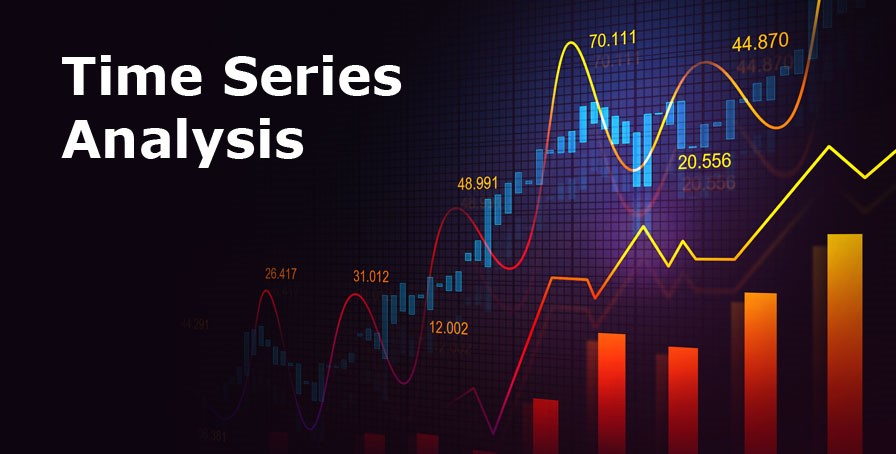

> **Time series is a sequence or series of data points in which the time component is involved throughout the occurrence and Analyzing this time series data with certain tools and techniques is called time series analysis.**

[Click Here](https://www.analyticsvidhya.com/blog/2021/06/time-series-analysis-a-comprehensive-guide/)  to know more about Time series analysis.

Here, we have a last 5 years Stock Data of the most fastest growing company which is TESLA.

In this notebook, You will be going to learn following: 
- **EDA Techniques**
- **Plotting basic charts using Plotly**
- **Easily learn about Time series analysis using GRU neural network** 
- **Prediction next 30 days** 

<a name="lib"></a>

# Import libraries and packages

In [1]:
import os
import pandas as pd
import numpy as np
import math
import datetime as dt

from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score 
from sklearn.metrics import mean_poisson_deviance, mean_gamma_deviance, accuracy_score
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import LSTM, GRU

from itertools import cycle
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots


# Import Dataset

In [2]:
maindf = pd.read_csv('../input/tesla-stock-data-20162021/TSLA.csv')
maindf = maindf.rename(columns={'Date': 'date','Open':'open','High':'high','Low':'low','Close':'close',
                                'Adj Close':'adj_close','Volume':'volume'})
maindf.head()

,date,open,high,low,close,adj_close,volume
0,2016-08-16,45.098000,45.438000,44.681999,44.722000,44.722000,11335500
1,2016-08-17,44.866001,44.966000,44.560001,44.647999,44.647999,8935500
2,2016-08-18,44.764000,45.132000,44.458000,44.702000,44.702000,8572500
3,2016-08-19,44.708000,45.034000,44.506001,45.000000,45.000000,8297500
4,2016-08-22,44.834000,45.021999,44.535999,44.585999,44.585999,10327500


In [3]:
print("Total number of days: ",maindf.shape[0])
print("Total number of fields: ",maindf.shape[1])

Total number of days:  1258
Total number of fields:  7


<a name="na"></a>

# Checking Null and NA value

In [4]:
print("Null values:", maindf.isnull().values.sum())
print("NA values:", maindf.isna().values.any())

Null values: 0
NA values: False


<a name="predate"></a>

# Convert Date field into datetime format

In [5]:
# convert date field from string to Date format 
maindf['date'] = pd.to_datetime(maindf.date)
maindf.head()

,date,open,high,low,close,adj_close,volume
0,2016-08-16,45.098000,45.438000,44.681999,44.722000,44.722000,11335500
1,2016-08-17,44.866001,44.966000,44.560001,44.647999,44.647999,8935500
2,2016-08-18,44.764000,45.132000,44.458000,44.702000,44.702000,8572500
3,2016-08-19,44.708000,45.034000,44.506001,45.000000,45.000000,8297500
4,2016-08-22,44.834000,45.021999,44.535999,44.585999,44.585999,10327500


<a name="eda"></a>

# EDA - Exploratory Data Analysis

<a name="dur"></a>

### Find the duration of dataset

In [6]:
print("Starting date: ",maindf.iloc[0][0])
print("Ending date: ", maindf.iloc[-1][0])
print("Duration: ", maindf.iloc[-1][0]-maindf.iloc[0][0])

Starting date:  2016-08-16 00:00:00
Ending date:  2021-08-13 00:00:00
Duration:  1823 days 00:00:00


<a name="oc"></a>

### Monthwise comparision between Stock open and close price

In [7]:
monthvise= maindf.groupby(maindf['date'].dt.strftime('%B'))[['open','close']].mean()
new_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 
             'September', 'October', 'November', 'December']
monthvise = monthvise.reindex(new_order, axis=0)
monthvise

,open,close
date,,
January,211.862118,212.589568
February,227.558569,227.040441
March,194.185782,193.161236
April,205.595030,205.671611
May,181.159451,180.826095
June,204.369197,204.726543
July,226.404302,226.023074
August,173.212144,174.174936
September,129.064456,128.870416


In [8]:
fig = go.Figure()

fig.add_trace(go.Bar(
    x=monthvise.index,
    y=monthvise['open'],
    name='Stock Open Price',
    marker_color='crimson'
))
fig.add_trace(go.Bar(
    x=monthvise.index,
    y=monthvise['close'],
    name='Stock Close Price',
    marker_color='lightsalmon'
))

fig.update_layout(barmode='group', xaxis_tickangle=-45, 
                  title='Monthwise comparision between Stock open and close price')
fig.show()

<a name="hl"></a>

### Monthwise High and Low stock price 

In [9]:
maindf.groupby(maindf['date'].dt.strftime('%B'))['low'].min()
monthvise_high = maindf.groupby(maindf['date'].dt.strftime('%B'))['high'].max()
monthvise_high = monthvise_high.reindex(new_order, axis=0)

monthvise_low = maindf.groupby(maindf['date'].dt.strftime('%B'))['low'].min()
monthvise_low = monthvise_low.reindex(new_order, axis=0)

fig = go.Figure()
fig.add_trace(go.Bar(
    x=monthvise_high.index,
    y=monthvise_high,
    name='Stock high Price',
    marker_color='rgb(0, 153, 204)'
))
fig.add_trace(go.Bar(
    x=monthvise_low.index,
    y=monthvise_low,
    name='Stock low Price',
    marker_color='rgb(255, 128, 0)'
))

fig.update_layout(barmode='group', 
                  title=' Monthwise High and Low stock price')
fig.show()

<a name="trend"></a>

### Trend comparision between stock open price, close price, high price, low price

In [10]:
names = cycle(['Stock Open Price','Stock Close Price','Stock High Price','Stock Low Price'])

fig = px.line(maindf, x=maindf.date, y=[maindf['open'], maindf['close'], 
                                          maindf['high'], maindf['low']],
             labels={'date': 'Date','value':'Stock value'})
fig.update_layout(title_text='Stock analysis chart', font_size=15, font_color='black',legend_title_text='Stock Parameters')
fig.for_each_trace(lambda t:  t.update(name = next(names)))
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)

fig.show()

<a name="sc"></a>

**Here, We are going to predict close price for next 30 days**

# Prepare Stock Close price

<a name="df"></a>

### Make separate dataframe of close price

In [11]:
closedf = maindf[['date','close']]
print("Shape of close dataframe:", closedf.shape)

Shape of close dataframe: (1258, 2)


<a name="pclose"></a>

### Plotting Stock Close price chart

In [12]:
fig = px.line(closedf, x=closedf.date, y=closedf.close,labels={'date':'Date','close':'Close Stock'})
fig.update_traces(marker_line_width=2, opacity=0.8)
fig.update_layout(title_text='Stock close price chart', plot_bgcolor='white', font_size=15, font_color='black')
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

<a name="year"></a>

# Consider only last 1 year data for prediction

In [13]:
closedf = closedf[closedf['date'] > '2020-08-16']
close_stock = closedf.copy()
print("Total data for prediction: ",closedf.shape[0])

Total data for prediction:  251


In [14]:
fig = px.line(closedf, x=closedf.date, y=closedf.close,labels={'date':'Date','close':'Close Stock'})
fig.update_traces(marker_line_width=2, opacity=0.8, marker_line_color='orange')
fig.update_layout(title_text='Considered period to predict Stock close price', plot_bgcolor='white', font_size=15, font_color='black')
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

<a name="norm"></a>

### Normalizing close price

In [15]:
del closedf['date']
scaler=MinMaxScaler(feature_range=(0,1))
closedf=scaler.fit_transform(np.array(closedf).reshape(-1,1))
print(closedf.shape)

(251, 1)


<a name="split"></a>

### Prepare Data for train and test

In [16]:
training_size=int(len(closedf)*0.60)
test_size=len(closedf)-training_size
train_data,test_data=closedf[0:training_size,:],closedf[training_size:len(closedf),:1]
print("train_data: ", train_data.shape)
print("test_data: ", test_data.shape)

train_data:  (150, 1)
test_data:  (101, 1)


<a name="trans"></a>

### Transform Close price base on Time-series-analysis forecasting requirement

Look at the below image to get bit of understanding about create dataset for forecasting time-series-analysis


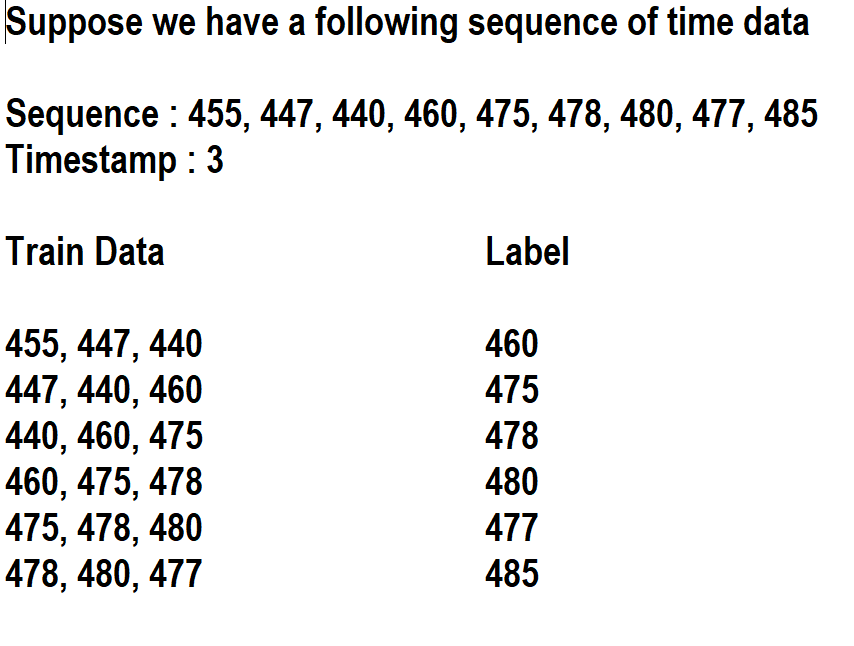


In [17]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----99   100 
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

In [18]:
time_step = 15
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

print("X_train: ", X_train.shape)
print("y_train: ", y_train.shape)
print("X_test: ", X_test.shape)
print("y_test", y_test.shape)

X_train:  (134, 15)
y_train:  (134,)
X_test:  (85, 15)
y_test (85,)


In [19]:
# reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

print("X_train: ", X_train.shape)
print("X_test: ", X_test.shape)

X_train:  (134, 15, 1)
X_test:  (85, 15, 1)


<a name="gru"></a>

# Model Building (GRU)

**GRUs (Gated Recurrent Units) are very similar to Long Short Term Memory(LSTM). Just like LSTM, GRU uses gates to control the flow of information. They are relatively new as compared to LSTM. This is the reason they offer some improvement over LSTM and have simpler architecture.**

Image reference: [Here](http://dprogrammer.org/rnn-lstm-gru)

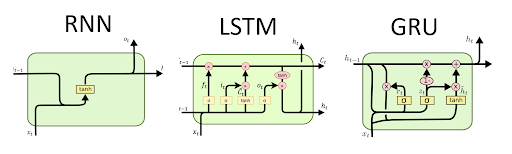

Follow below reference links tto know more about GRU and LSTM:

- [Comprehensive guide about GRU](https://www.analyticsvidhya.com/blog/2021/03/introduction-to-gated-recurrent-unit-gru/)

- [Comprehensive guide about LSTM](https://colah.github.io/posts/2015-08-Understanding-LSTMs/)

In [20]:
tf.keras.backend.clear_session()
model=Sequential()
model.add(GRU(32,return_sequences=True,input_shape=(time_step,1)))
model.add(GRU(32,return_sequences=True))
model.add(GRU(32))
model.add(Dropout(0.20))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [21]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 15, 32)            3360      
_________________________________________________________________
gru_1 (GRU)                  (None, 15, 32)            6336      
_________________________________________________________________
gru_2 (GRU)                  (None, 32)                6336      
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 33        
Total params: 16,065
Trainable params: 16,065
Non-trainable params: 0
_________________________________________________________________


In [22]:
history = model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=200,batch_size=32,verbose=1)

Epoch 1/200
5/5 [==============================] - 7s 407ms/step - loss: 0.1682 - val_loss: 0.0131
Epoch 2/200
5/5 [==============================] - 0s 42ms/step - loss: 0.0273 - val_loss: 0.0304
Epoch 3/200
5/5 [==============================] - 0s 43ms/step - loss: 0.0324 - val_loss: 0.0049
Epoch 4/200
5/5 [==============================] - 0s 42ms/step - loss: 0.0158 - val_loss: 0.0043
Epoch 5/200
5/5 [==============================] - 0s 40ms/step - loss: 0.0171 - val_loss: 0.0039
Epoch 6/200
5/5 [==============================] - 0s 40ms/step - loss: 0.0142 - val_loss: 0.0037
Epoch 7/200
5/5 [==============================] - 0s 40ms/step - loss: 0.0106 - val_loss: 0.0071
Epoch 8/200
5/5 [==============================] - 0s 39ms/step - loss: 0.0132 - val_loss: 0.0026
Epoch 9/200
5/5 [==============================] - 0s 38ms/step - loss: 0.0093 - val_loss: 0.0037
Epoch 10/200
5/5 [==============================] - 0s 39ms/step - loss: 0.0104 - val_loss: 0.0025
Epoch 11/200
5/5 [

<a name="loss"></a>

### Plotting loss chart

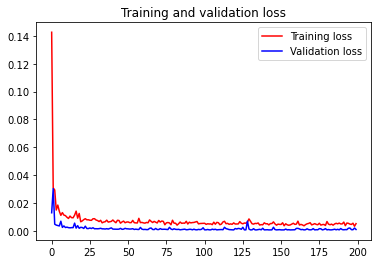

<Figure size 432x288 with 0 Axes>

In [23]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.figure()


plt.show()

In [24]:
### Lets Do the prediction and check performance metrics
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)
train_predict.shape, test_predict.shape

((134, 1), (85, 1))

<a name="eval"></a>

# Model Evaluation

In [25]:
# Transform back to original form

train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)
original_ytrain = scaler.inverse_transform(y_train.reshape(-1,1)) 
original_ytest = scaler.inverse_transform(y_test.reshape(-1,1)) 

<a name="mse"></a>

### Evaluation metrices RMSE, MSE and MAE

Root Mean Square Error (RMSE), Mean Square Error (MSE) and Mean absolute Error (MAE) are a standard way to measure the error of a model in predicting quantitative data.

In [26]:
# Evaluation metrices RMSE and MAE
print("Train data RMSE: ", math.sqrt(mean_squared_error(original_ytrain,train_predict)))
print("Train data MSE: ", mean_squared_error(original_ytrain,train_predict))
print("Train data MAE: ", mean_absolute_error(original_ytrain,train_predict))
print("-------------------------------------------------------------------------------------")
print("Test data RMSE: ", math.sqrt(mean_squared_error(original_ytest,test_predict)))
print("Test data MSE: ", mean_squared_error(original_ytest,test_predict))
print("Test data MAE: ", mean_absolute_error(original_ytest,test_predict))

Train data RMSE:  28.085895463668294
Train data MSE:  788.8175239961033
Train data MAE:  20.94405245160914
-------------------------------------------------------------------------------------
Test data RMSE:  18.43638314015615
Test data MSE:  339.9002232906339
Test data MAE:  14.730777544898892


<a name="var"></a>

### Explained variance regression score


The explained variance score explains the dispersion of errors of a given dataset, and the formula is written as follows: Here, and Var(y) is the variance of prediction errors and actual values respectively. Scores close to 1.0 are highly desired, indicating better squares of standard deviations of errors.

In [27]:
print("Train data explained variance regression score:", explained_variance_score(original_ytrain, train_predict))
print("Test data explained variance regression score:", explained_variance_score(original_ytest, test_predict))

Train data explained variance regression score: 0.972391962214507
Test data explained variance regression score: 0.8889520156157568


<a name="r2"></a>

### R<sup>2</sup> score for regression

R-squared (R2) is a statistical measure that represents the proportion of the variance for a dependent variable that's explained by an independent variable or variables in a regression model.

1 = Best <br>
0 or < 0 = worse

In [28]:
print("Train data R2 score:", r2_score(original_ytrain, train_predict))
print("Test data R2 score:", r2_score(original_ytest, test_predict))

Train data R2 score: 0.9715621656081017
Test data R2 score: 0.8487387952440832


<a name="mpd"></a>

### Regression Loss Mean Gamma deviance regression loss (MGD) and Mean Poisson deviance regression loss (MPD)

In [29]:
print("Train data MGD: ", mean_gamma_deviance(original_ytrain, train_predict))
print("Test data MGD: ", mean_gamma_deviance(original_ytest, test_predict))
print("----------------------------------------------------------------------")
print("Train data MPD: ", mean_poisson_deviance(original_ytrain, train_predict))
print("Test data MPD: ", mean_poisson_deviance(original_ytest, test_predict))

Train data MGD:  0.0024874979807327645
Test data MGD:  0.0007845547011750168
----------------------------------------------------------------------
Train data MPD:  1.3476680858716505
Test data MPD:  0.5149937600745489


<a name="cp"></a>

# Comparision of original stock close price and predicted close price

In [30]:
# shift train predictions for plotting

look_back=time_step
trainPredictPlot = np.empty_like(closedf)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
print("Train predicted data: ", trainPredictPlot.shape)

# shift test predictions for plotting
testPredictPlot = np.empty_like(closedf)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(closedf)-1, :] = test_predict
print("Test predicted data: ", testPredictPlot.shape)

names = cycle(['Original close price','Train predicted close price','Test predicted close price'])


plotdf = pd.DataFrame({'date': close_stock['date'],
                       'original_close': close_stock['close'],
                      'train_predicted_close': trainPredictPlot.reshape(1,-1)[0].tolist(),
                      'test_predicted_close': testPredictPlot.reshape(1,-1)[0].tolist()})

fig = px.line(plotdf,x=plotdf['date'], y=[plotdf['original_close'],plotdf['train_predicted_close'],
                                          plotdf['test_predicted_close']],
              labels={'value':'Stock price','date': 'Date'})
fig.update_layout(title_text='Comparision between original close price vs predicted close price',
                  plot_bgcolor='white', font_size=15, font_color='black', legend_title_text='Close Price')
fig.for_each_trace(lambda t:  t.update(name = next(names)))

fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

Train predicted data:  (251, 1)
Test predicted data:  (251, 1)


<a name="days"></a>

# Predicting next 30 days

In [31]:
x_input=test_data[len(test_data)-time_step:].reshape(1,-1)
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=time_step
i=0
pred_days = 30
while(i<pred_days):
    
    if(len(temp_input)>time_step):
        
        x_input=np.array(temp_input[1:])
        #print("{} day input {}".format(i,x_input))
        x_input = x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        
        yhat = model.predict(x_input, verbose=0)
        #print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
       
        lst_output.extend(yhat.tolist())
        i=i+1
        
    else:
        
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        
        lst_output.extend(yhat.tolist())
        i=i+1
               
print("Output of predicted next days: ", len(lst_output))

Output of predicted next days:  30


<a name="pdays"></a>

### Plotting last 15 days of dataset and next predicted 30 days

In [32]:
last_days=np.arange(1,time_step+1)
day_pred=np.arange(time_step+1,time_step+pred_days+1)
print(last_days)
print(day_pred)

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
[16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39
 40 41 42 43 44 45]


In [33]:
temp_mat = np.empty((len(last_days)+pred_days+1,1))
temp_mat[:] = np.nan
temp_mat = temp_mat.reshape(1,-1).tolist()[0]

last_original_days_value = temp_mat
next_predicted_days_value = temp_mat

last_original_days_value[0:time_step+1] = scaler.inverse_transform(closedf[len(closedf)-time_step:]).reshape(1,-1).tolist()[0]
next_predicted_days_value[time_step+1:] = scaler.inverse_transform(np.array(lst_output).reshape(-1,1)).reshape(1,-1).tolist()[0]

new_pred_plot = pd.DataFrame({
    'last_original_days_value':last_original_days_value,
    'next_predicted_days_value':next_predicted_days_value
})

names = cycle(['Last 15 days close price','Predicted next 30 days close price'])

fig = px.line(new_pred_plot,x=new_pred_plot.index, y=[new_pred_plot['last_original_days_value'],
                                                      new_pred_plot['next_predicted_days_value']],
              labels={'value': 'Stock price','index': 'Timestamp'})
fig.update_layout(title_text='Compare last 15 days vs next 30 days',
                  plot_bgcolor='white', font_size=15, font_color='black',legend_title_text='Close Price')

fig.for_each_trace(lambda t:  t.update(name = next(names)))
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

<a name="pwhole"></a>

### Plotting entire Closing Stock Price with next 30 days period of prediction 

In [34]:
lstmdf=closedf.tolist()
lstmdf.extend((np.array(lst_output).reshape(-1,1)).tolist())
lstmdf=scaler.inverse_transform(lstmdf).reshape(1,-1).tolist()[0]

names = cycle(['Close price'])

fig = px.line(lstmdf,labels={'value': 'Stock price','index': 'Timestamp'})
fig.update_layout(title_text='Plotting whole closing stock price with prediction',
                  plot_bgcolor='white', font_size=15, font_color='black',legend_title_text='Stock')

fig.for_each_trace(lambda t:  t.update(name = next(names)))

fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()